# KEN3450, Data Analysis, Spring 2020

### Clinic 3: Classification in Python

**Hristo Minkov - i6161227**

**Check the honor policy code posted on the portal before reusing code you found online**

***
### Learning Goals:

By the end of this clinic, you should be able to:

* Run Classification Models (Logistic Regression, Decision Trees, Random Forests, etc.) in Python
* Explain and tackle issues like missing values or class inbalance in your dataset
* Judge the results of a classification model using AUROC scores
* Select a proper algorithm that works well with your data using techniques (see also last week) like:
    * Cross Validation
    * Regularization

***

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, auc
%matplotlib inline
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

c:\users\hmi\appdata\local\programs\python\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\hmi\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\hmi\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


## Part 1: Determine the Inbalance (Asymmetry)

First, we would like to notice in our data that they are highly unbalanced (assymetric). Load the data which should contain 9 columns (`health`, `age`, `sex`, `educ`, `sexornt`, `partyid`, `race`, `married`, `income`). `Age`, `educ` (how many years of education a person has) and `income` are quantitative, the others are qualitative.

In [2]:
gssdata=pd.read_csv("gssdata4.csv")
gssdata.head()

,health,age,sex,educ,sexornt,partyid,race,married,income
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN


Our goal is to predict if a person is in poor health or not. Let's create some dummy variables in order to measure that.

In [3]:
poorhealth = np.where(gssdata['health'] == 'poor',1,0)
excellenthealth = np.where(gssdata['health'] == 'excellent',1,0)
fairhealth = np.where(gssdata['health'] == 'fair',1,0)
gssdata['poorhealth'] = poorhealth
gssdata['fairhealth'] = fairhealth
gssdata['excellenthealth'] = excellenthealth

In [4]:
gssdata.describe
gssdata.head(10)

,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,fairhealth,excellenthealth
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,0,1
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,0,1
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,0,0
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,0,1
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,0,0
5,excellent,30,female,15,heterosexual or straight,other,other,1,18750.0,0,0,1
6,fair,43,female,5,heterosexual or straight,other,other,1,NaN,0,1,0
7,poor,56,male,11,heterosexual or straight,other,white,0,NaN,1,0,0
8,good,69,male,8,heterosexual or straight,other,white,1,NaN,0,0,0
9,excellent,30,female,14,heterosexual or straight,other,black,1,16250.0,0,0,1


Can you quantify what is the degree of inbalance? Mention a percentage of the split between the positive and the negative class.

* What is the majority and the minority class?
* What would be the accuracy of a classifier that predicts everybody NOT being in poor health?
* Discuss why accuracy is not a good metric.

Value counts: 
0    1452
1      99
Name: poorhealth, dtype: int64

Pecentages: 
Positive class: 6%
Negative class: 94%


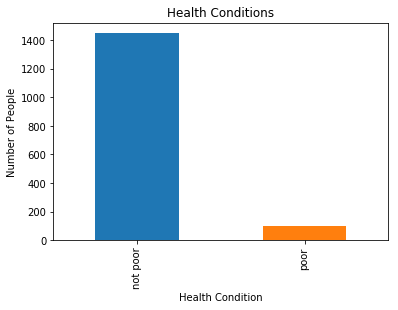

In [5]:
print('Value counts: ')
print(gssdata['poorhealth'].value_counts())

neg_count = gssdata['poorhealth'].value_counts()[0]
pos_count = gssdata['poorhealth'].value_counts()[1]

print('\nPecentages: ')
print('Positive class: ' + str(int(round(100 * pos_count / (pos_count + neg_count)))) + '%')
print('Negative class: ' + str(int(round(100 * neg_count / (pos_count + neg_count)))) + '%')

plot_counts = gssdata['poorhealth'].value_counts().plot(kind="bar")
plot_counts.set_xticklabels(['not poor', 'poor'])

plt.xlabel('Health Condition')
plt.ylabel('Number of People')
plt.title('Health Conditions')

plt.show()

## <font color='green'>ANSWER:</font>
1. Our goal is to classify whether the person is in poor health or not. There are 1452 negative examples and 99 positive.
This shows that approximately 94% of the data constitutes the negative samples and 6% - the positive. The majority class is the 'individuals with not poor health' and the minority - the 'individuals with poor health'.

2. Accuracy for classifier that predicts everybody not beeing in poor health = (TP + TN) / (TP + TN + FP + FN) = (0 + 1452) / (0 + 1452 + 0 + 99) = 1452 / 1551 = 0.93617

3. In that sense, accuracy is not a good metric since the dataset is really imbalanced towards the negative class. It generally measures how much of the examples were classified correctly. This is missleading in our problem as most of the data points are negative and the model might learn to predict only one of the classes because of that. A much more precise metric would take into account not only the precision (like the accuracy) but also the recall. It is generally a good idea to pick a metric that focuses on the individuals with poor health as this is the essential goal of our work.

## Part 2: Fit a logistic model ignoring missing values

Let's begin by fitting a logistic regression model to predict poor health based on several of the other predictors in the model. In part 3, you will be asked to regularize (with cross-validation) to make sure you do not overfit, but for this part, we will keep things simple.

First, we need to do a small amount of data clean-up (ignoring missingness for now in `income`). Best practice would be to split into train/test first before looking at the data, but again, we can keep it simple in this part.

In [6]:
#creating dummies two ways
gssdata['female'] = 1*(gssdata['sex'] ==  'female')
dummy_vars = pd.get_dummies(gssdata[['sexornt','partyid','race']])
gssdata = gssdata.join(dummy_vars)

In [7]:
#Let's get a sense of the data we have
print(gssdata.shape)
gssdata.head()

(1551, 23)


,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,0,0,1,0,0,0,1,0,0,1
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,0,0,1,0,0,0,1,0,0,1
2,good,59,male,13,heterosexual or straight,rep,white,1,NaN,0,...,0,0,1,0,0,0,1,0,0,1
3,excellent,74,female,17,heterosexual or straight,other,white,1,NaN,0,...,0,0,1,0,0,1,0,0,0,1
4,poor,37,female,10,heterosexual or straight,other,white,0,NaN,1,...,0,0,1,0,0,1,0,0,0,1


### Looking at missing values

In [8]:
print('Missing values:')
print(gssdata.isnull().sum())

Missing values:
health                                0
age                                   0
sex                                   0
educ                                  0
sexornt                               0
partyid                               0
race                                  0
married                               0
income                              588
poorhealth                            0
fairhealth                            0
excellenthealth                       0
female                                0
sexornt_bisexual                      0
sexornt_dont know                     0
sexornt_heterosexual or straight      0
sexornt_homosexual or gay             0
partyid_dem                           0
partyid_other                         0
partyid_rep                           0
race_black                            0
race_other                            0
race_white                            0
dtype: int64


### Preparing data

In [9]:
y_columns = ['poorhealth']
X_columns = list(gssdata.columns)
[X_columns.remove(x) for x in ['poorhealth', 'sexornt', 'sex', 'health', 'race', 'partyid', 'income']]

X, y = gssdata[X_columns].values, gssdata[y_columns].values

### Training a Logistic Regression model

In [10]:
clf = LogisticRegression(max_iter=1000).fit(X, y)

c:\users\hmi\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Plotting the confusion matrix

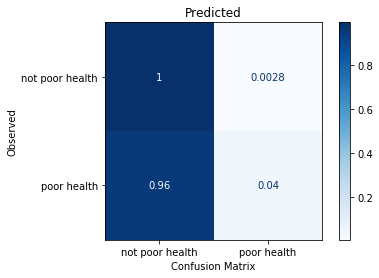

In [11]:
plot_confusion_matrix(clf, X, y, display_labels=['not poor health', 'poor health'],
                     cmap=plt.cm.Blues, normalize='true')

plt.xlabel('Confusion Matrix')
plt.ylabel('Observed')
plt.title('Predicted')

plt.show()

---

## 2a: Handling missingness approach \#1: remove observations. 

We do not know how sklearn will treat the missing values (the `NaN`s), so we should do handle them ourselves.  As a base case, let's remove all observations with missingness.

In [12]:
##In the code below: Remove all observations that are not complete
##Report on how many samples were dropped.

gssdata_full = gssdata.copy()

initial_count_datapoints = gssdata_full.shape[0]

gssdata_full = gssdata_full.dropna()

dropped_count_datapoints = gssdata_full.shape[0]

print('Number of dropped samples:')
print(initial_count_datapoints - dropped_count_datapoints)

Number of dropped samples:
588


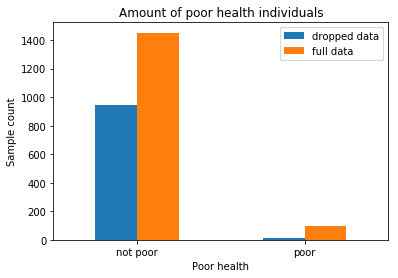

In [13]:
#Do a quick check to see how dropping observations affected the amount of poor health individuals
#Do an appropriate plot to show this (e.g. boxplot)

dropped_data = gssdata_full['poorhealth'].value_counts()
full_data = gssdata['poorhealth'].value_counts()

df = pd.DataFrame({'dropped data': dropped_data,
                   'full data': full_data})

ax = df.plot.bar(rot=0)
ax.set_xticklabels(['not poor', 'poor'])

plt.xlabel('Poor health')
plt.ylabel('Sample count')
plt.title('Amount of poor health individuals')

plt.show()

In [14]:
gssdata_full.head() #<---this should be your final data frame.

,health,age,sex,educ,sexornt,partyid,race,married,income,poorhealth,...,sexornt_bisexual,sexornt_dont know,sexornt_heterosexual or straight,sexornt_homosexual or gay,partyid_dem,partyid_other,partyid_rep,race_black,race_other,race_white
0,excellent,53,male,16,heterosexual or straight,rep,white,1,18750.0,0,...,0,0,1,0,0,0,1,0,0,1
1,excellent,26,female,16,heterosexual or straight,rep,white,1,18750.0,0,...,0,0,1,0,0,0,1,0,0,1
5,excellent,30,female,15,heterosexual or straight,other,other,1,18750.0,0,...,0,0,1,0,0,1,0,0,1,0
9,excellent,30,female,14,heterosexual or straight,other,black,1,16250.0,0,...,0,0,1,0,0,1,0,1,0,0
12,good,38,female,15,heterosexual or straight,dem,white,0,18750.0,0,...,0,0,1,0,1,0,0,0,0,1


In [15]:
#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

itrain, itest = train_test_split(range(gssdata_full.shape[0]), test_size=0.25, random_state=42)

gsstemp = gssdata_full[['age','educ','female','partyid_dem','partyid_rep','income']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_full['poorhealth'].iloc[itrain]
y_test = gssdata_full['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((722,), (722, 6), (241,), (241, 6))

In [16]:
#####################
# Your code here: fit a logistic model with C=1000000 and evaluate classification accuracy on the test set.
# Then move below to be reminded on the confusion matrix
#####################

logit = LogisticRegression(C=1_000_000, random_state=42).fit(X_train, y_train)

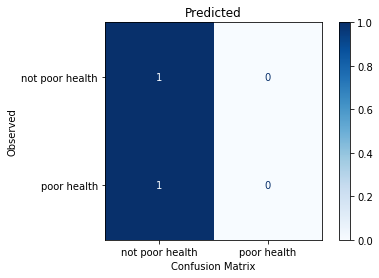

In [17]:
plot_confusion_matrix(logit, X_test, y_test, display_labels=['not poor health', 'poor health'],
                     cmap=plt.cm.Blues, normalize='true')

plt.xlabel('Confusion Matrix')
plt.ylabel('Observed')
plt.title('Predicted')

plt.show()

In [18]:
print('Mean accuracy on the given test data and labels:')
print(logit.score(X_test, y_test))

Mean accuracy on the given test data and labels:
0.975103734439834


## Reminder: The Confusion Matrix & Some Useful Functions

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![confusionmatrix](./confusionmatrix_360.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`



Confusion matrix:
[[235   0]
 [  6   0]]


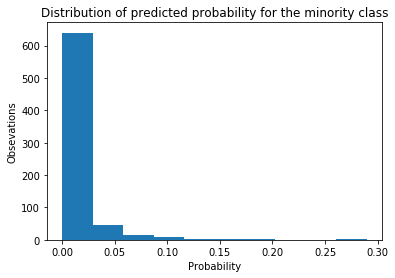

In [19]:
print('Confusion matrix:')
print(confusion_matrix(y_test,logit.predict(X_test)))

yhats = logit.predict_proba(X_train)
hist = plt.hist(yhats[:,1])

plt.xlabel('Probability')
plt.ylabel('Obsevations')
plt.title('Distribution of predicted probability for the minority class')

plt.show()

The following function can be used to create confusion tables with different thresholds (same as we did in the last example of the lecture slides)

In [20]:
###manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t) * 1
    return ypred

In [21]:
print('Confusion matrix over the test set with threshold = .03')
print(confusion_matrix(y_test,t_repredict(logit, .03, X_test)))

print('\nConfusion matrix over the train set with threshold = .03')
print(confusion_matrix(y_train,t_repredict(logit, .03, X_train)))

Confusion matrix over the test set with threshold = .03
[[210  25]
 [  6   0]]

Confusion matrix over the train set with threshold = .03
[[639  73]
 [  6   4]]


The following fuction should create ROC curves for your models, based on the model and the ground truth. Feel free to change it and improve it!

In [22]:
#name: name of your model to appear on the figure (can be arbitrary)
#clf: the model as you named it - will be used for getting the predictions
#ytest, xtest: your test data
#skip, labe: steps that control how many points you see in the ROC curve and how many labels are there

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM? (but double-check this pleaseee)
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    
    #this is the single value for the AUC score
    roc_auc = auc(fpr, tpr)
    
    if skip: 
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    
    #add labels to the curve
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

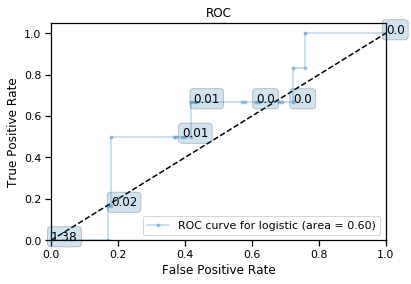

In [23]:
#This is how the above function should be used
sns.set_context("notebook")
ax=make_roc("logistic", logit, y_test, X_test, labe=4, skip=0)

## Let's get back the data with missingness

It's time to build a model to impute the missing data!

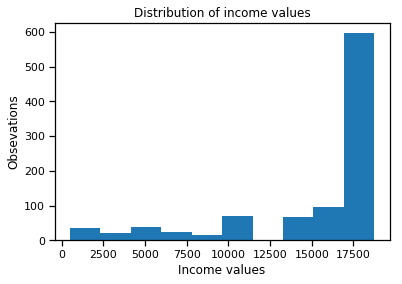

In [24]:
plt.hist(gssdata_full['income'])

plt.xlabel('Income values')
plt.ylabel('Obsevations')
plt.title('Distribution of income values')

plt.show()

---

## 2b: Handling missingness approach \#2: impute the mean 

In your first approach, make a copy of the original data frame and impute the missing values by assuming that every missing value should be replaced by the mean. Make sure to do a histogram as well and compare it with the original!

Then fit a model (as before in 2a.) and judge the model accuracy. Use the functions for the ROC curve to establish the result.

In [25]:
#back to the original data set with missingness, make a copy, and then impute the mean, plot it!

gssdata_mean = gssdata.copy()

gssdata_mean['income'] = gssdata_mean['income'].fillna(gssdata_mean['income'].mean())

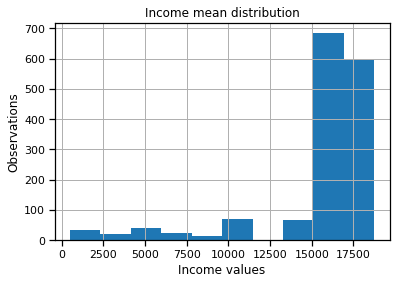

In [26]:
gssdata_mean['income'].hist(bins=10)

plt.xlabel('Income values')
plt.ylabel('Observations')
plt.title('Income mean distribution')

plt.show()

In [27]:
itrain, itest = train_test_split(range(gssdata_mean.shape[0]), test_size=0.25, random_state=42)

gsstemp = gssdata_mean[['age','educ','female','partyid_dem','partyid_rep','income']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_mean['poorhealth'].iloc[itrain]
y_test = gssdata_mean['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((1163,), (1163, 6), (388,), (388, 6))

In [28]:
logit_mean = LogisticRegression(C=1_000_000, random_state=42).fit(X_train, y_train)

y_pred = logit_mean.predict(X_test)

print('Mean accuracy on the given test data and labels:')
print(logit_mean.score(X_test, y_test))

Mean accuracy on the given test data and labels:
0.9149484536082474


In [29]:
print('Confusion matrix over the test set with threshold = .08')
print(confusion_matrix(y_test,t_repredict(logit_mean, .08, X_test)))

print('\nConfusion matrix over the train set with threshold = .08')
print(confusion_matrix(y_train,t_repredict(logit_mean, .08, X_train)))

Confusion matrix over the test set with threshold = .08
[[278  78]
 [ 17  15]]

Confusion matrix over the train set with threshold = .08
[[869 227]
 [ 29  38]]


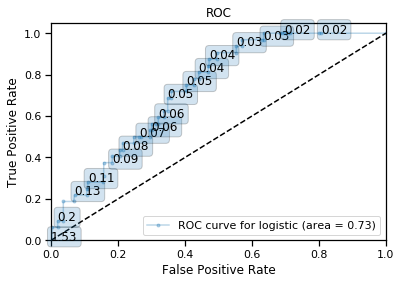

In [30]:
ax=make_roc("logistic",logit_mean, y_test, X_test, labe=4, skip=0)

---

## 2c: Handling missingness approach \#3: impute with a model (linear regression here)

The third and most sophisticated approach would be to fit a linear model (multiple regression) to estimate income based on the other features (`age`, `educ`, `sex`, `partyid`). Train this model below and then use it in order to compute the missing values.

In [31]:
#use the dataset without NAs here - gssdata_full

itrain, itest = train_test_split(range(gssdata_full.shape[0]), test_size=0.25, random_state=42)

gsstemp = gssdata_full[['age','educ','female','partyid_dem','partyid_rep', 'partyid_other']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = gssdata_full['income'].iloc[itrain]
y_test = gssdata_full['income'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((722,), (722, 6), (241,), (241, 6))

In [32]:
reg_income = LinearRegression().fit(X_train, y_train)

print('The coefficient of determination R^2 of the prediction:')
print(reg_income.score(X_test, y_test))

The coefficient of determination R^2 of the prediction:
0.17388320934210189


In [33]:
#####################
# your code here: 
# 1. figure out which observations have missing values for income,
# 2. create the values you will use for imputation by:
#  - calculating (1) the predicted values for the observations with missingness using the linear model 
# 3. use these values to impute back into the income variable in the missing entries
# 4. Do a histogram to see how does that look like
#####################

missing_income = gssdata[gssdata['income'].isnull()]
have_income = gssdata[~gssdata['income'].isnull()]

print(missing_income.shape[0], have_income.shape[0])

588 963


In [34]:
gsstemp = missing_income[['age','educ','female','partyid_dem','partyid_rep', 'partyid_other']]
incomes = reg_income.predict(gsstemp.values)

missing_income = missing_income.assign(income=incomes)

combined_gss = pd.concat([missing_income, have_income])

print('Shape of the combined gss data:')
print(combined_gss.shape)

Shape of the combined gss data:
(1551, 23)


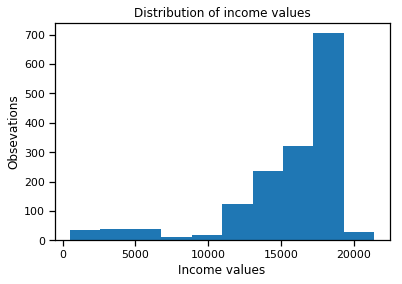

In [35]:
plt.hist(combined_gss['income'])

plt.xlabel('Income values')
plt.ylabel('Obsevations')
plt.title('Distribution of income values')

plt.show()

In [36]:
print('Missing values on the combined gss data:')
print(combined_gss.isnull().sum())

Missing values on the combined gss data:
health                              0
age                                 0
sex                                 0
educ                                0
sexornt                             0
partyid                             0
race                                0
married                             0
income                              0
poorhealth                          0
fairhealth                          0
excellenthealth                     0
female                              0
sexornt_bisexual                    0
sexornt_dont know                   0
sexornt_heterosexual or straight    0
sexornt_homosexual or gay           0
partyid_dem                         0
partyid_other                       0
partyid_rep                         0
race_black                          0
race_other                          0
race_white                          0
dtype: int64


Then fill the missing data with the results you got. You can do that multiple ways, one way to use Python would be the following:

In [37]:
#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste

itrain, itest = train_test_split(range(combined_gss.shape[0]), test_size=0.25, random_state=42)

gsstemp = combined_gss[['age','educ','female','partyid_dem','partyid_rep','income']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = combined_gss['poorhealth'].iloc[itrain]
y_test = combined_gss['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((1163,), (1163, 6), (388,), (388, 6))

In [38]:
logit_model = LogisticRegression(C=1_000_000, random_state=42).fit(X_train, y_train)

y_pred = logit_model.predict(X_test)

print('Mean accuracy on the given test data and labels:')
print(logit_model.score(X_test, y_test))

Mean accuracy on the given test data and labels:
0.9278350515463918


In [39]:
print('Confusion matrix over the test set with threshold = .08')
print(confusion_matrix(y_test,t_repredict(logit_model, .08, X_test)))

print('\nConfusion matrix over the train set with threshold = .08')
print(confusion_matrix(y_train,t_repredict(logit_model, .08, X_train)))

Confusion matrix over the test set with threshold = .08
[[282  78]
 [ 13  15]]

Confusion matrix over the train set with threshold = .08
[[846 246]
 [ 32  39]]


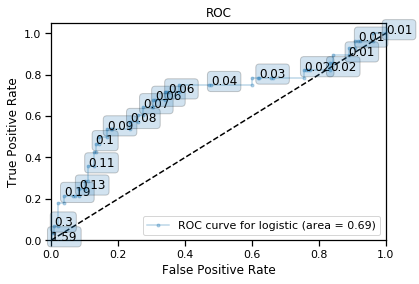

In [40]:
ax=make_roc("logistic", logit_model, y_test, X_test, labe=4, skip=0)

Which model performs the best when it comes to missing values? Use this cell to report your observations and be critical about them.

## <font color='green'>ANSWER:</font>

During the 2nd part of the assignment we evaluated the performance of 3 models that differ by the way they handle missingness in data:
1. Ignore missing income values (NaNs)
2. Impute by the mean value
3. Impute by multiple regression model

One thing to note here is that the main problem within the dataset was not that most of the income values were missing but rather that the dataset was highly imbalanced towards the majority class (people with 'not poor' health). There are many ways to tackle the imbalanced data:
1. Use the appropriate evaluation metric
2. Undersampling
3. Oversampling
4. Use K-fold cross-validation (in a right way)
5. Ensemble different resampled (undersampling/oversampling) datasets
6. Resample using different ratios
7. Undersampling/Oversampling using imbalanced-learn
    * Undersampling using Tomek Links
    * Oversampling using SMOTE (Synthetic Minority Oversampling Technique)
8. Class weights in the models
9. Regularization

As we can see, there are numerous approaches to the imbalance issue and in this notebook we explore the effect of using the appropriate evaluation metric - AUROC (#1), in the next step - K-fold cross-validation and Regularizaion (#4 and #9) and we used a form of putting class weights (#8) when computing the confusion matrix with different thresholds.

The three approaches were evaluated using the ROC curve and more specificlly, on the AUROC metric. This allowed for more precise results as it takes into account the true positive rate (TPR) and the false positive rate (FPR). These evluation metrics bring more meaning to our models in that particular case but are not generally better than accuracy!

The AUROC results for the previously mentioned models with different missingness handling are as follows:
1. Ignore missing income values (NaNs): 0.67
2. Impute by the mean value: 0.73
3. Impute by multiple regression model: 0.69

It seems that the 'impute by mean' approach works best for out current setting (data and problem definition). However, this does not necessarily mean that this imputation would outperform the others in any general task. Moreover, there are many more imputing mechanisms that could potentially lead to a better solution to the health classification task - e.g. we can regard the missing values from the 'income' parameter as an indication that the person has no job. Or maybe we should descretize the income column space into classes [low income, no_income, avg_income and high_income]. All those approaches might lead to larger AUROC. Therefore, we should always do a smart guess on what should be a good approach and try to start from there. Of course, before that happening, it's better to dive deep into the data and its characteristics in the first place. After all, the dataset is the initiator to all those models that have to deal with unbalanced data.

As a follow up on this assignment, one could extensively examine the performance on other techniques to tackle not only the 'income' column missingness but also the high imbalance of the data by using the above approaches. This might lead to a very different solution that outperforms the current ones. Moreover, the Logistic Regression is one of the simplest classifiers, so a good idea would be to substitute that with a more powerful machine learning algorithm or go directly for a Deep Neural Network (in that case one should still be careful with the data characteristics and pick an appropriate architecture).

---

## Part 3: Improving the model.

Apply regularization (with cross-validation) to make sure not to overfit to the data and try also different models, like a Decision Tree or a Random Forest. Report on your results for which model handles inbalances in the best way.

### 3.1 Data preparation

In [41]:
#Now we will split the data before fitting any models, feel free to change this/adapt this to your taste
itrain, itest = train_test_split(range(combined_gss.shape[0]), test_size=0.25, random_state=42)

gsstemp = combined_gss[['age','educ','female','partyid_dem','partyid_rep','income']]

X_train = gsstemp.iloc[itrain, :]
X_test = gsstemp.iloc[itest, :]
y_train = combined_gss['poorhealth'].iloc[itrain]
y_test = combined_gss['poorhealth'].iloc[itest]

y_train.shape, X_train.shape, y_test.shape, X_test.shape

((1163,), (1163, 6), (388,), (388, 6))

### 3.2 Logistic Regression with cross-validation

In [42]:
log_reg_model_cv = LogisticRegressionCV(cv=5, random_state=42).fit(X_train, y_train)

In [43]:
y_pred = log_reg_model_cv.predict(X_test)

print('Mean accuracy on the given test data and labels:')
print(log_reg_model_cv.score(X_test, y_test))

Mean accuracy on the given test data and labels:
0.9278350515463918


In [44]:
print('Confusion matrix over the test set with threshold = .08')
print(confusion_matrix(y_test, t_repredict(log_reg_model_cv, .08, X_test)))

print('\nConfusion matrix over the train set with threshold = .08')
print(confusion_matrix(y_train, t_repredict(log_reg_model_cv, .08, X_train)))

Confusion matrix over the test set with threshold = .08
[[289  71]
 [ 13  15]]

Confusion matrix over the train set with threshold = .08
[[862 230]
 [ 36  35]]


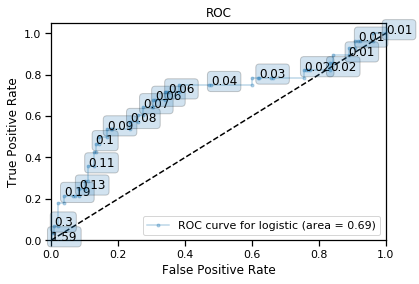

In [45]:
ax=make_roc("logistic", logit_model, y_test, X_test, labe=4, skip=0)

### 3.3 Logistic Regression with high regularization

In [46]:
logit_model = LogisticRegression(C=0.01, penalty='l2', random_state=42).fit(X_train, y_train)

In [47]:
y_pred = logit_model.predict(X_test)

print('Mean accuracy on the given test data and labels:')
print(logit_model.score(X_test, y_test))

Mean accuracy on the given test data and labels:
0.9252577319587629


In [48]:
print('Confusion matrix over the test set with threshold = .08')
print(confusion_matrix(y_test, t_repredict(logit_model, .08, X_test)))

print('\nConfusion matrix over the train set with threshold = .08')
print(confusion_matrix(y_train, t_repredict(logit_model, .08, X_train)))

Confusion matrix over the test set with threshold = .08
[[281  79]
 [ 13  15]]

Confusion matrix over the train set with threshold = .08
[[830 262]
 [ 32  39]]


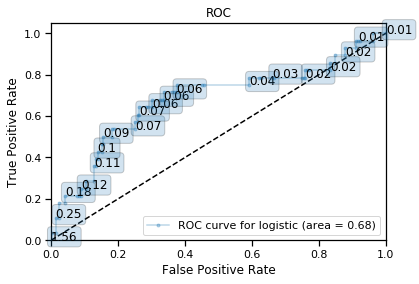

In [49]:
ax=make_roc("logistic", logit_model, y_test, X_test, labe=4, skip=0)

### 3.4 Decision Tree Classifier

In [50]:
dec_tree_model = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [51]:
y_pred = dec_tree_model.predict(X_test)

print('Mean accuracy on the given test data and labels:')
print(dec_tree_model.score(X_test, y_test))

Mean accuracy on the given test data and labels:
0.8891752577319587


In [52]:
print('Confusion matrix over the test set with threshold = .08')
print(confusion_matrix(y_test, t_repredict(dec_tree_model, .08, X_test)))

print('\nConfusion matrix over the train set with threshold = .08')
print(confusion_matrix(y_train, t_repredict(dec_tree_model, .08, X_train)))

Confusion matrix over the test set with threshold = .08
[[338  22]
 [ 25   3]]

Confusion matrix over the train set with threshold = .08
[[1082   10]
 [   0   71]]


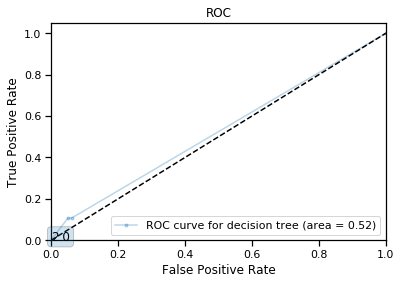

In [53]:
ax=make_roc("decision tree", dec_tree_model, y_test, X_test, labe=4, skip=0)

### 3.5 Random Forest Classifier

In [54]:
rand_forest_model = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [55]:
y_pred = rand_forest_model.predict(X_test)

print('Mean accuracy on the given test data and labels:')
print(rand_forest_model.score(X_test, y_test))

Mean accuracy on the given test data and labels:
0.9149484536082474


In [56]:
print('Confusion matrix over the test set with threshold = .08')
print(confusion_matrix(y_test, t_repredict(rand_forest_model, .08, X_test)))

print('\nConfusion matrix over the train set with threshold = .08')
print(confusion_matrix(y_train, t_repredict(rand_forest_model, .08, X_train)))

Confusion matrix over the test set with threshold = .08
[[295  65]
 [ 16  12]]

Confusion matrix over the train set with threshold = .08
[[1017   75]
 [   0   71]]


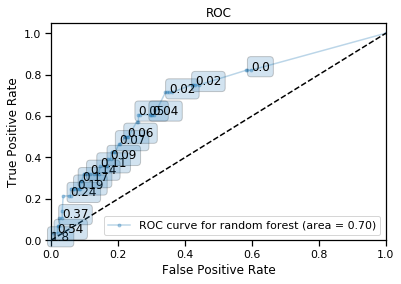

In [57]:
ax=make_roc("random forest", rand_forest_model, y_test, X_test, labe=4, skip=0)

### 3.6 XGBoost Classifier

In [58]:
xgboost_model = XGBClassifier(random_state=42).fit(X_train, y_train)

In [59]:
y_pred = xgboost_model.predict(X_test)

print('Mean accuracy on the given test data and labels:')
print(xgboost_model.score(X_test, y_test))

Mean accuracy on the given test data and labels:
0.9278350515463918


In [60]:
print('Confusion matrix over the test set with threshold = .08')
print(confusion_matrix(y_test, t_repredict(xgboost_model, .08, X_test)))

print('\nConfusion matrix over the train set with threshold = .08')
print(confusion_matrix(y_train, t_repredict(xgboost_model, .08, X_train)))

Confusion matrix over the test set with threshold = .08
[[288  72]
 [ 11  17]]

Confusion matrix over the train set with threshold = .08
[[878 214]
 [  4  67]]


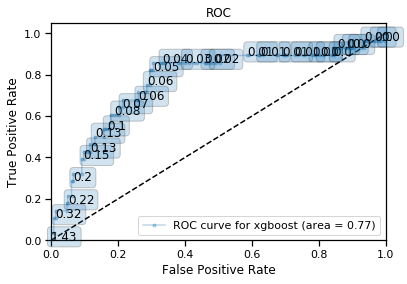

In [61]:
ax=make_roc("xgboost", xgboost_model, y_test, X_test, labe=4, skip=0)

Your comments go here. Make sure you document and comment on each step of your approach. Also, make sure that you sufficiently comment on the results and be critical. Which approach worked the best? How did they handle missingness?

## <font color='green'>ANSWER:</font>

The part 3 of this Data Analysis assignment focuses on improving the models using different approaches. Those techniques or new model architectures were introduced above:
1. Logistic Regression with cross-validation
2. Logistic Regression with high regularization
3. Decision Tree classifier
4. Random Forest classifier
5. XGBoost classifier

The reason behind choosing those 5 additional tests lays on the ground of my intention to add variety to our experiments. First of all, we test the performance on KFold cross-validation and regularization (#1 and #2) to observe the behavior of our simple Logistic Regression model. Following, we introduce a rather simple Decision Tree classifier (#3) that is notorious with its inability to handle imbalanced data. Next, we showcase an ensemble model - Random Forest classifier (#4) and realize that such a model could benefit the problem as it involves 'voting' from various submodels. At the end, we focus on the power of a gradient boosting model - XGBoost (#5) to show that gradient boosting is an effective modern machine learning technique that adds on to simple Decision Tree classifiers and ensemble methods. It generalizes other boosting models by allowing optimization of an arbitrary differentiable loss function.

The data preparation process included choosing one of the missingness data handling techniques and applying Sklearn's train/test split with random seed on several columns that we used in part 2. We use the model imputed data as this would allow for additional data to come to for the multiple regression model and improve it. This additional complexity will add on to the main model's AUROC score. We also pick the same columns as part 2 for the sake of fair comparison between the approaches.

The results of the subsection in terms of the AUROC scores are as follows:
1. Logistic Regression with cross-validation: 0.69
2. Logistic Regression with high regularization: 0.68
3. Decision Tree classifier: 0.52
4. Random Forest classifier: 0.70
5. XGBoost classifier: 0.77

As we can conclude from the results above, the additions to the simple Logistic Regression model added more 'correctness' (#1 and #2). Then, the Decision Tree classifier (#3) proved to be notorious when dealing with highly imbalanced data, scoring very close to random models' performance. Following, the enemble method added more complexity and eventually improved the AUROC score. Finally, the modern powerfull approach that combines the above models' strengths does the best with 0.77 AUROC score even without transforming the imbalanced data.

As a conclusion, we would suggest that there might be an enormous amount of models, techniques and approaches to the problems within the data, but one should never focus solely on one of those but do a 'smart guess' and evaluate the performance of many of the suggestions and only then come to a mere approximation of the 'correct' solution.